### Importing Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import PorterStemmer
from keras import models
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.layers import *
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Using TensorFlow backend.


### Fetching Data

In [61]:
dfTrain = pd.read_csv('./Subtask-A/V1.4_Training.csv',header=None,encoding='latin-1')
dfTest = pd.read_csv('./Subtask-A/SubtaskA_Trial_Test_Labeled.csv',encoding='latin-1')

In [62]:
dfTest.head()

,id,sentence,label
0,1310_1,I'm not asking Microsoft to Gives permission l...,1
1,1312_1,somewhere between Android and iPhone.,0
2,1313_1,And in the Windows Store you can flag the App ...,0
3,1313_2,"Many thanks Sameh Hi, As we know, there is a l...",0
4,1313_3,The idea is that we can develop a regular app ...,1


In [63]:
dfTest.head()

,id,sentence,label
0,1310_1,I'm not asking Microsoft to Gives permission l...,1
1,1312_1,somewhere between Android and iPhone.,0
2,1313_1,And in the Windows Store you can flag the App ...,0
3,1313_2,"Many thanks Sameh Hi, As we know, there is a l...",0
4,1313_3,The idea is that we can develop a regular app ...,1


In [7]:
#storing useful data i.e column 1 and 2 in xTrain and yTrain
dataTrain= dfTrain.values
dataTrain = dataTrain[:,1:]
dataXTrain = dataTrain[:,0]
dataYTrain = dataTrain[:,1]
print(dataXTrain.shape,dataYTrain.shape)

(8500,) (8500,)


In [8]:
#storing useful data i.e column 1 and 2 and samples from row 1 in xTest and yTest
dataTest= dfTest.values
dataTest = dataTest[1:,1:]
dataXTest = dataTest[:,0]
dataYTest = dataTest[:,1]
print(dataXTest.shape,dataYTest.shape)

(592,) (592,)


In [10]:
dataYTrain = np.array(dataYTrain,dtype = 'int64')
dataYTest = np.array(dataYTest,dtype = 'int64')

### Cleaning and Tokenising Data

In [11]:
stopw = set(stopwords.words("english"))
ps = PorterStemmer()

In [12]:
# method to tokenize the sentence and remove stopwords(having no information) along with their stemming
def filterData(text): 
    data = []
    for i in text:
        sentences = nltk.sent_tokenize(i)
        for sent in sentences:
            words =  nltk.word_tokenize(sent)
            words = [w.lower() for w in words if len(w)>2 and w not in stopw]
            words = [ps.stem(w) for w in words]
            data.append(words)
    return data

In [13]:
xTrain = np.array(filterData(dataXTrain))
print(xTrain[0])
xTest = np.array(filterData(dataXTest))
print(xTest[4])

['pleas', 'enabl', 'remov', 'languag', 'code', 'dev', 'center', 'languag', 'histori', 'for', 'exampl', 'ever', 'select', 'ru-ru', 'laguag', 'publish', 'xap', 'store', 'caus', 'tile', 'local', 'show', 'en-u', 'default', 'tile', 'local', 'bad']
['the', 'idea', 'develop', 'regular', 'app', 'request', 'permiss', 'manifest', 'app', 'ask', 'for', 'trust_æ_']
['thi', 'would', 'enabl', 'live', 'traffic', 'awar', 'app']


In [14]:
yTrain = to_categorical(dataYTrain)  # Converting yTrain and yTest to one Hot vector i.e label 0 will be represented as [1 0]
print(yTrain.shape)
yTest = to_categorical(dataYTest)
print(yTest.shape)

(8500, 2)
(592, 2)


In [15]:
# method to get list/length of uniue words in the text so as to make their vector(no of unique words = size of vector)
def getUniqueSet(X):
    wordSet = set()
    maxLen = 0
    for sent in X:
        wordSet.update(sent)
        if(maxLen<len(sent)):
            maxLen = len(sent)

    vocabSize = len(list(wordSet))
    #print(vocabSize)
    #print(maxLen)
    return vocabSize,maxLen

In [16]:
vocabSize,maxLen = getUniqueSet(xTrain)

In [17]:
# converting text to vectors where each word in a sentence is replaced by it's index in the tokenized dict
myTokenizer = Tokenizer(num_words=vocabSize)
myTokenizer.fit_on_texts(list(xTrain))
xTrain = myTokenizer.texts_to_sequences(xTrain)
xTest = myTokenizer.texts_to_sequences(xTest)
xTrain = sequence.pad_sequences(xTrain, maxLen) # padding to make length of vectors of each sentence equal
xTest = sequence.pad_sequences(xTest, maxLen)

In [18]:
print(xTrain.shape,xTest.shape)

(8755, 336) (601, 336)


### Training LSTM Model

In [39]:
#early stopping is used to prevent overfitting i.e trainig is stopped as soon as we get the best accuracy or least loss
earlyStopping = EarlyStopping(min_delta = 0.001,monitor='val_acc', patience = 5)
callback = [earlyStopping]

# checkpoint to store the best fit model
checkpoint = ModelCheckpoint("best_model.h5",monitor='val_loss',verbose=True,save_best_only=True)

#defining the model and it's layers
model = Sequential()
# Embedding is done to convert sparse vectors to dense vectors so as to reduce the no. of parameters and hence the training time
model.add(Embedding(vocabSize,256,input_length=maxLen))
#model.add(LSTM(64,return_sequences=False))
#model.add(Dropout(0.4))
model.add(LSTM(64,return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(2,activation='relu'))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 336, 256)          2163200   
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                82176     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
_________________________________________________________________
activation_3 (Activation)    (None, 2)                 0         
Total params: 2,245,506
Trainable params: 2,245,506
Non-trainable params: 0
_________________________________________________________________


In [40]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
model.fit(xTrain[:8000],yTrain[:8000],batch_size=32,epochs=10,shuffle=True,validation_split=0.2,callbacks=[checkpoint,earlyStopping])

Train on 6400 samples, validate on 1600 samples
Epoch 1/10
6400/6400 [==============================] - 89s 14ms/step - loss: 0.5480 - acc: 0.7684 - val_loss: 0.7956 - val_acc: 0.6150

Epoch 00001: val_loss improved from inf to 0.79561, saving model to best_model.h5
Epoch 2/10
6400/6400 [==============================] - 86s 13ms/step - loss: 0.4729 - acc: 0.7827 - val_loss: 0.8832 - val_acc: 0.6034

Epoch 00002: val_loss did not improve from 0.79561
Epoch 3/10
6400/6400 [==============================] - 89s 14ms/step - loss: 0.3414 - acc: 0.8501 - val_loss: 1.1043 - val_acc: 0.5675

Epoch 00003: val_loss did not improve from 0.79561
Epoch 4/10
6400/6400 [==============================] - 84s 13ms/step - loss: 0.2489 - acc: 0.8996 - val_loss: 1.4820 - val_acc: 0.5906

Epoch 00004: val_loss did not improve from 0.79561
Epoch 5/10
6400/6400 [==============================] - 84s 13ms/step - loss: 0.1828 - acc: 0.9292 - val_loss: 1.7499 - val_acc: 0.5844

Epoch 00005: val_loss did not im

### Predicting and Testing

In [147]:
predTrain = model.predict_classes(xTrain)
predTest = model.predict_classes(xTest)

In [151]:
cnfTrain = confusion_matrix(predTrain[:8500],dataYTrain)
cnfTest = confusion_matrix(predTest[:592],dataYTest)

In [36]:
# Function ot visualize confusion matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[6095  710]
 [ 320 1375]]


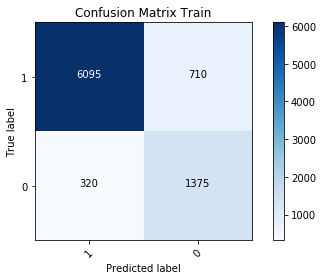

In [153]:
plot_confusion_matrix(cnfTrain,classes=[1,0],title="Confusion Matrix Train")

In [155]:
print(classification_report(predTrain[:8500],dataYTrain))

              precision    recall  f1-score   support

           0       0.95      0.90      0.92      6805
           1       0.66      0.81      0.73      1695

   micro avg       0.88      0.88      0.88      8500
   macro avg       0.80      0.85      0.82      8500
weighted avg       0.89      0.88      0.88      8500



Confusion matrix, without normalization
[[238 227]
 [ 58  69]]


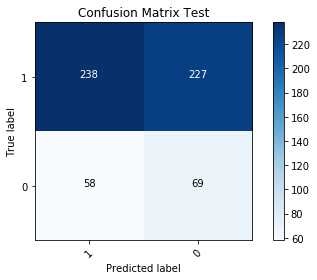

In [156]:
plot_confusion_matrix(cnfTest,classes=[1,0],title="Confusion Matrix Test")

In [158]:
print(classification_report(predTest[:592],dataYTest))

              precision    recall  f1-score   support

           0       0.80      0.51      0.63       465
           1       0.23      0.54      0.33       127

   micro avg       0.52      0.52      0.52       592
   macro avg       0.52      0.53      0.48       592
weighted avg       0.68      0.52      0.56       592



### Generating Submission File

In [41]:
dfEval = pd.read_csv('./Subtask-A/SubtaskA_EvaluationData.csv',header=None,encoding='latin-1')

In [42]:
dfEval.head()

,0,1,2
0,9566,This would enable live traffic aware apps.,X
1,9569,Please try other formatting like bold italics ...,X
2,9576,Since computers were invented to save time I s...,X
3,9577,Allow rearranging if the user wants to change ...,X
4,9579,Add SIMD instructions for better use of ARM NE...,X


In [54]:
#storing useful data i.e column 1 and 2 in xEval and yEval
dataEval= dfEval.values
dataEval = dataEval[:,1:]
dataXEval = dataEval[:,0]
dataYEval = dataEval[:,1]
print(dataXEval.shape,dataYEval.shape)

xEval = np.array(filterData(dataXEval))
print(xEval[0])

(833,) (833,)
['thi', 'would', 'enabl', 'live', 'traffic', 'awar', 'app']


In [55]:
xEval = myTokenizer.texts_to_sequences(xEval)
xEval = sequence.pad_sequences(xEval, maxLen)
xEval = xEval[:833]

In [56]:
predictedEval = model.predict_classes(xEval)

In [65]:
dfEval[2] = predictedEval

In [66]:
dfEval.head()

,0,1,2
0,9566,This would enable live traffic aware apps.,0
1,9569,Please try other formatting like bold italics ...,0
2,9576,Since computers were invented to save time I s...,0
3,9577,Allow rearranging if the user wants to change ...,0
4,9579,Add SIMD instructions for better use of ARM NE...,0


In [67]:
dfEval.to_csv('./kapil_gupta.csv')